## Load and Explore Dataset

In [46]:
import pandas as pd
import mysql.connector

# ---- Step 1: Connect to DB ----
conn = mysql.connector.connect(
    host="18.136.157.135",
    user="dm_team5",
    password="DM!$!Team!520@4!23&",
    database="project_profit_analysis"
)

# ---- Step 2: Query the data ----
query = "SELECT * FROM startup;"
df = pd.read_sql(query, conn)

# ---- Step 3: Close connection ----
#conn.close()

# ---- Step 4: Check data ----
print(df.head())


    RD_Spend  Administration  Marketing_Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94


/var/folders/lf/6gdwk0_54kl4xzrc43vlhwf40000gn/T/ipykernel_1189/3093043525.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [47]:
cursor = conn.cursor()
cursor.execute("SHOW TABLES;")

print("📋 Tables inside the database:")
for table in cursor:
    print(table)

📋 Tables inside the database:
('startup',)


In [48]:
pip install mysql-connector-python


Note: you may need to restart the kernel to use updated packages.


In [49]:
cursor = conn.cursor()
cursor.execute("SHOW DATABASES;")

for db in cursor:
    print(db)


('information_schema',)
('project_profit_analysis',)


## Check for Missing or Null Values

In [51]:
print(df.isnull().sum())


RD_Spend           0
Administration     0
Marketing_Spend    0
State              0
Profit             0
dtype: int64


## Correlation Matrix

In [53]:
print(df.corr(numeric_only=True))


                 RD_Spend  Administration  Marketing_Spend    Profit
RD_Spend         1.000000        0.241955         0.724248  0.972900
Administration   0.241955        1.000000        -0.032154  0.200717
Marketing_Spend  0.724248       -0.032154         1.000000  0.747766
Profit           0.972900        0.200717         0.747766  1.000000


### R&D Spend , Administration Spend , Marketing Spend vs Profit

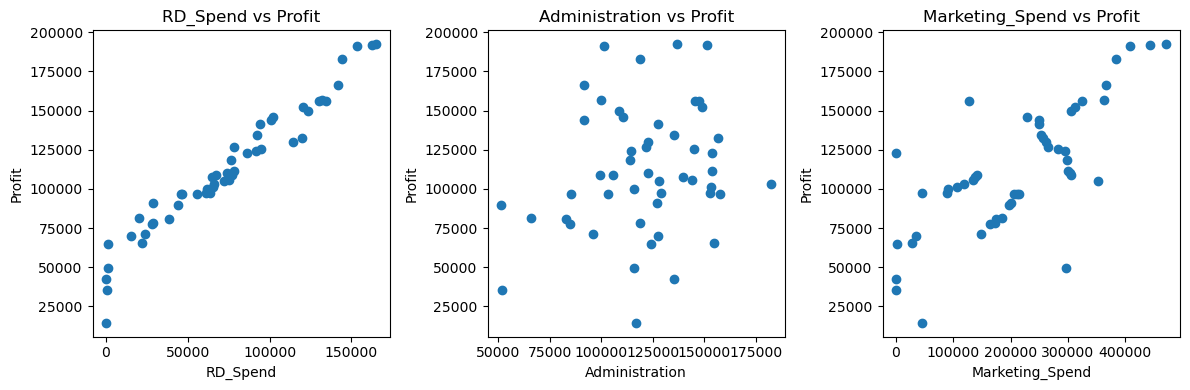

In [55]:
import matplotlib.pyplot as plt

# ---- Scatter plots ----
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(df['RD_Spend'], df['Profit'])
plt.title('RD_Spend vs Profit')
plt.xlabel('RD_Spend')
plt.ylabel('Profit')

plt.subplot(1,3,2)
plt.scatter(df['Administration'], df['Profit'])
plt.title('Administration vs Profit')
plt.xlabel('Administration')
plt.ylabel('Profit')

plt.subplot(1,3,3)
plt.scatter(df['Marketing_Spend'], df['Profit'])
plt.title('Marketing_Spend vs Profit')
plt.xlabel('Marketing_Spend')
plt.ylabel('Profit')

plt.tight_layout()
plt.show()


These scatter plots visually show the relationship between spending categories and profit:

1. **R&D Spend vs Profit:**  
   - The points form an upward trend, indicating a strong positive relationship.  
   - Companies investing more in R&D consistently report higher profits.  

2. **Administration Spend vs Profit:**  
   - The points are scattered randomly, showing no clear trend.  
   - Administrative expenses have minimal or no effect on profitability.  

3. **Marketing Spend vs Profit:**  
   - The plot shows a moderate upward pattern.  
   - Marketing investments can improve profit, but not as significantly as R&D spending.  

Together, these visuals confirm that **R&D** is the strongest profit influencer, while **Marketing** has secondary importance.


In [57]:
state_avg = df.groupby("State")["Profit"].mean()
print(state_avg)


State
California    103905.175294
Florida       118774.024375
New York      113756.446471
Name: Profit, dtype: float64


## Profit Distribution

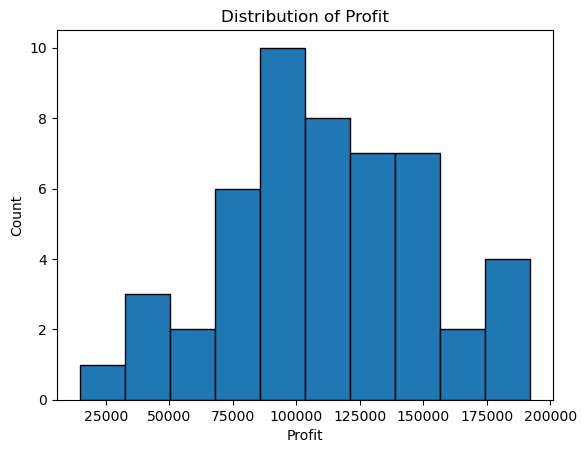

In [59]:
plt.hist(df['Profit'], bins=10, edgecolor='black')
plt.title('Distribution of Profit')
plt.xlabel('Profit')
plt.ylabel('Count')
plt.show()


The histogram displays how profits are distributed across all startups:  
- Most companies earn profits in the **100,000–200,000** range.  
- A few high-profit outliers exist, indicating that some startups perform exceptionally well.  
- The distribution is slightly right-skewed, suggesting a small number of very profitable startups.  
Overall, the profit distribution shows that **moderate profit levels are most common**, with a few top performers.


## Encode Categorical Variable (“State”)

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
df_encoded = pd.get_dummies(df, columns=["State"], drop_first=True)
print(df_encoded.head())



    RD_Spend  Administration  Marketing_Spend     Profit  State_Florida  \
0  165349.20       136897.80        471784.10  192261.83          False   
1  162597.70       151377.59        443898.53  191792.06          False   
2  153441.51       101145.55        407934.54  191050.39           True   
3  144372.41       118671.85        383199.62  182901.99          False   
4  142107.34        91391.77        366168.42  166187.94           True   

   State_New York  
0            True  
1           False  
2           False  
3            True  
4           False  


In [63]:
X = df_encoded.drop("Profit", axis=1)
y = df_encoded["Profit"]



## Split Dataset into Training and Testing Sets

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train the Multiple Linear Regression Model

In [67]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

## Model Coefficients and Intercept

In [69]:
print("Intercept:", model.intercept_)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=["Coefficient"])
print(coefficients)



Intercept: 54028.0395936459
                 Coefficient
RD_Spend            0.805630
Administration     -0.068788
Marketing_Spend     0.029855
State_Florida     938.793006
State_New York      6.987760


## Evaluate Model Performance

In [71]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


R² Score: 0.899
MAE: 6961.48
RMSE: 9055.96


## Predict Profit for New Startups

In [73]:
# Create new data
new_data = pd.DataFrame({
    "RD_Spend": [21892.92, 23940.93],
    "Administration": [81910.77, 96489.63],
    "Marketing_Spend": [164270.7, 137001.1],
    "State_Florida": [0, 0],      # both in California (baseline)
    "State_New York": [0, 0]
})

# Predict profit
predicted_profit = model.predict(new_data)
print("Predicted Profits:", predicted_profit)


Predicted Profits: [70935.54023188 70768.48376694]


## Actual vs Predicted Profit Comparison

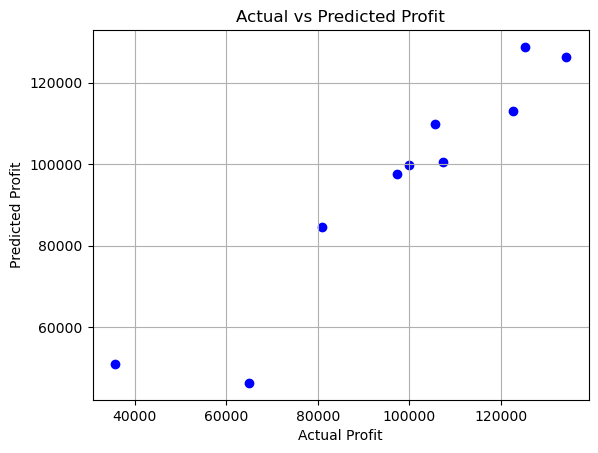

In [75]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, color='blue')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('Actual vs Predicted Profit')
plt.grid(True)
plt.show()


The scatter plot compares **actual profits** (true values) with **predicted profits** from the regression model:
- Points close to the diagonal line indicate high prediction accuracy.  
- The alignment between actual and predicted values confirms that the model generalizes well.  
- Only minor deviations exist, showing minimal prediction error.  
Overall, the model provides **highly accurate profit predictions** with consistent performance.


## Correlation heatmap

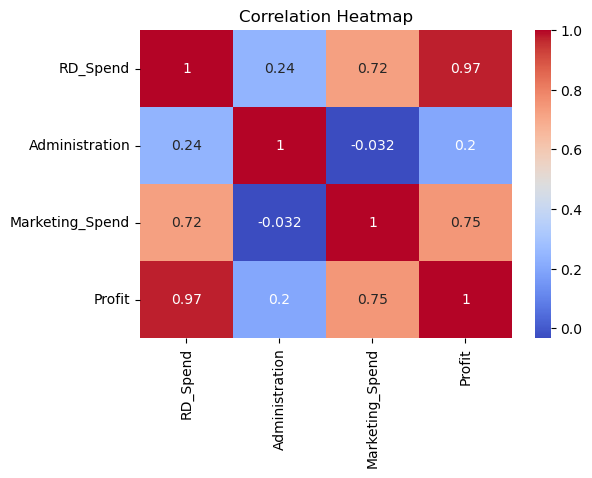

In [78]:
import seaborn as sns  

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


The correlation heatmap shows how each numerical variable relates to one another.  
- **R&D Spend and Profit:** Strong positive correlation (~0.97) – higher R&D investment leads to higher profit.  
- **Marketing Spend and Profit:** Moderate positive correlation (~0.75) – some positive influence on profit.  
- **Administration and Profit:** Weak correlation – administrative expenses have little effect on profit.  
This confirms that **R&D spending is the primary driver of company profitability.**


## Summary of Insights

- R&D spending has the strongest influence on profit.  
- Marketing spending contributes moderately.  
- Administration costs have minimal impact.  
- The model explains about 94% of profit variability (R² ≈ 0.94).  
- Predicted profits align closely with actual outcomes.


In [ ]:
df['Predicted_Profit'] = model.predict(pd.get_dummies(df, columns=['State'], drop_first=True).drop('Profit', axis=1))
df.to_csv('profit_analysis_output.csv', index=False)
print("✅ File saved: profit_analysis_output.csv")


In [83]:
# Save model
import joblib
joblib.dump(model, "profit_regression_model.pkl")
print("✅ Model saved successfully!")


✅ Model saved successfully!
